<b><i> Important Note: </i></b> This notebook was originally written in Colab, so this will not work here. 

# FineTuning MaskRCNN Instance Segmentation

This is a varation and heavily derivative of the Pytorch Tutorial [Finetuning MaskRCNN](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [0]:
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np

import os
import torch
import torch.utils.data

### Download some tools to make dataset COCO-ish

In [3]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

Cloning into 'cocoapi'...
remote: Enumerating objects: 959, done.
remote: Total 959 (delta 0), reused 0 (delta 0), pack-reused 959
Receiving objects: 100% (959/959), 11.69 MiB | 11.77 MiB/s, done.
Resolving deltas: 100% (570/570), done.
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/u

## Mount Google Drive Files

- My datasets live on google drive, so this mounts it onto the kernel and I can use files

<b> If you wanna run locally, you can change </b>`root='your/local/path'` <b>should work then. </b>

In [4]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


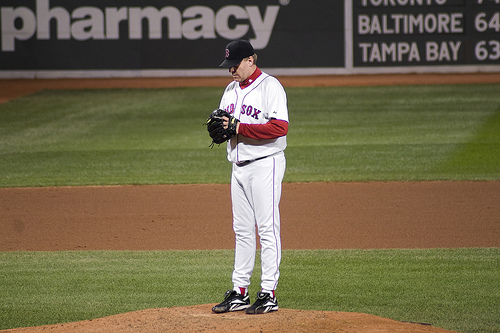

In [5]:
# test 
root= "/gdrive/My Drive/Colab Notebooks/cmu_masks"
i = Image.open(root + '/imgs/baseball.jpg')
i

## Prime the Data to Have the Correct Mask

### Define this helper function to show the mask and bounding box

In [0]:
def show_overlay(img, mask, bb=False):
  fig, axs = plt.subplots(1, figsize=(15,15))
  if type(bb) != bool:
    rect = pat.Rectangle( (bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth = 1, edgecolor= 'r', facecolor='none' )
    axs.add_patch(rect)

  masked = np.ma.masked_where(mask == 0, mask)
  plt.imshow(img, 'gray', interpolation='none')
  plt.imshow(masked, cmap='rainbow', interpolation='none', alpha=0.7)

### Lets play with the data to figure out what is happening

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask has this many values:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  35  36  37  39
 217 218 219 221 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]


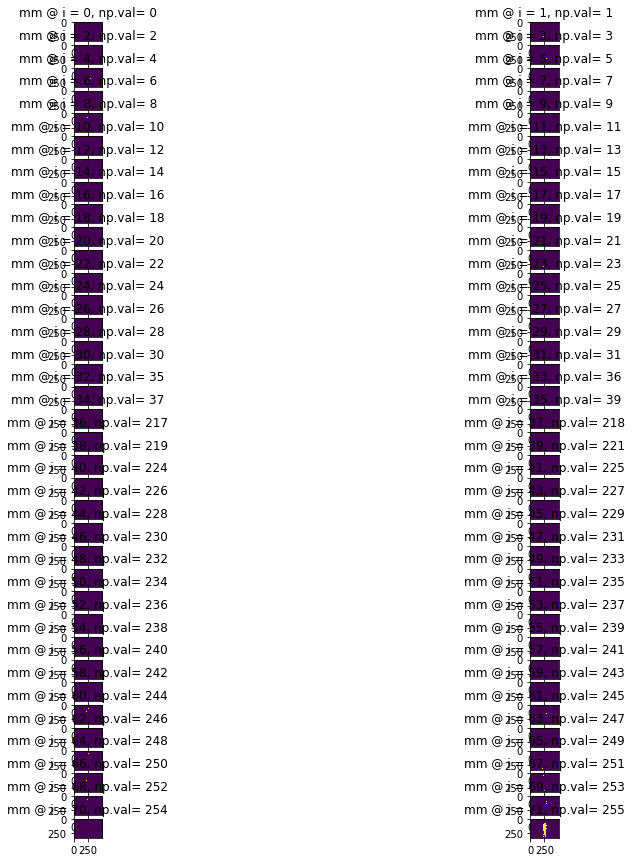

In [7]:
mask = Image.open(root+"/masks/baseball.jpg")
mask = np.array(mask)

print(mask)

print("mask has this many values: ", np.unique(mask))

unique_vals = np.unique(mask)

multi_mask = []
for i, val in enumerate(unique_vals):
  multi_mask.append(np.where(mask == val, mask, 0))
# print("mask has this many values: ", np.unique(mask))

# plt.imshow(multi_mask[5])

num_rows = len(multi_mask) // 2
fig, axs = plt.subplots(num_rows, 2, figsize=(15,15))
for r in range(num_rows):
  axs[r, 0].set_title(f"mm @ i = {r*2}, np.val= {unique_vals[r*2]}")
  axs[r, 0].imshow(multi_mask[r*2])
  axs[r, 1].set_title(f"mm @ i = {r * 2 +1}, np.val= {unique_vals[r*2+1]}")
  axs[r, 1].imshow(multi_mask[r*2 + 1])

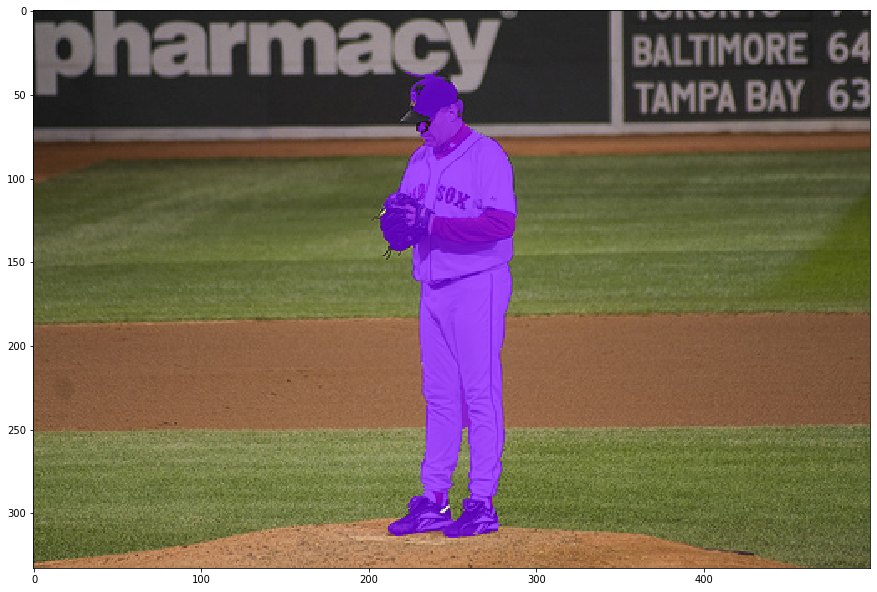

In [8]:
sw = np.where(mask < 217 , 0, 1) # 217 as some abritrary threshhold
img = np.array (Image.open(root+"/imgs/baseball.jpg"))

show_overlay(img, sw)

### Damn, I actually figured it out!
- The truth image was reading as a tonal image where some pixs were being interpolated as not just 0 or 255 for foreground or background... thats kinda wild. Rather, it was a grayscale image where its a range 0-255, black -> white
- interp_mask() is just playground on how image will be preprocessed. 

In [0]:
img_path = root+"/imgs/baseball.jpg"
mask_path = root + "/masks/baseball.jpg"

# open the img and mask

def interp_mask(name):
  img_path = root + f"/imgs/{name}"
  mask_path = root + f"/masks/{name}"

  img = Image.open(img_path).convert("RGB")
  mask = np.array(Image.open(mask_path))

  print("This is the img shape: ", np.array(img).shape)
  print("This is the mask shape: ", mask.shape)

  # masks
  tones = np.unique(mask)
  masks = [ np.where(mask < 200 , 0, 1) ] # for 1 size shit

  # boxes 
  boxes = []
  pos = np.where(masks[0])
  xmin = np.min(pos[1])
  xmax = np.max(pos[1])
  ymin = np.min(pos[0])
  ymax = np.max(pos[0])
  if (xmax - xmin) * (ymax - ymin) > 0:
    boxes.append([xmin, ymin, xmax, ymax])

  # area
  area = []
  area.append((xmax - xmin) * (ymax - ymin)) 

  # turn everything into a tensor
  masks = torch.as_tensor(masks, dtype=torch.uint8)
  boxes = torch.as_tensor(boxes, dtype=torch.float32)
  area = torch.as_tensor(area)

  image_id = torch.as_tensor([1]) # will change for later 
  labels = torch.ones((1,), dtype=torch.int64)
  is_crowd = torch.zeros((1,),  dtype=torch.int64)


  # construct elems 
  target = {}
  target['masks'] = masks
  target['boxes'] = boxes
  target['area'] = area
  
  target['image_id'] = image_id
  target['labels'] = labels
  target['is_crowd'] = is_crowd

  return img, target


This is the img shape:  (500, 400, 3)
This is the mask shape:  (500, 400)


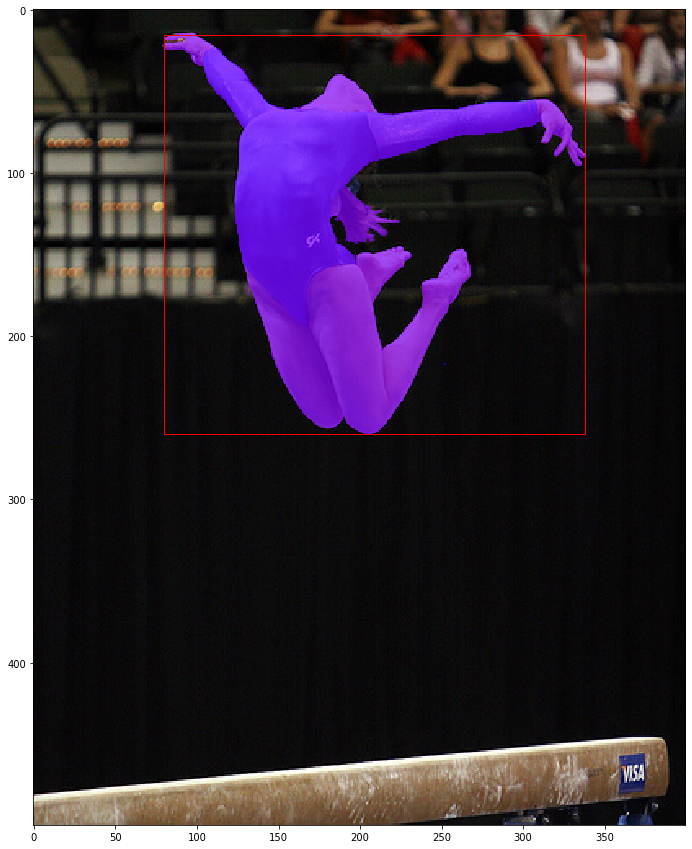

In [10]:
# test some stuff
dataset = interp_mask("223519917_d23c3f2c89.jpg")
# bb = dataset[1]['boxes'][0]

show_overlay(dataset[0], dataset[1]['masks'][0], dataset[1]['boxes'][0])
# fig, axs = plt.subplots(1, figsize=(15,15))
# axs.imshow(dataset[0])
# rect = pat.Rectangle( (bb[0], bb[1]), bb[2] - bb[0], bb[3] - bb[1], linewidth = 1, edgecolor= 'r', facecolor='none' )
# axs.add_patch(rect)
# axs.imshow(dataset[0] * np.array(dataset[1]['masks'][0])[:,:, np.newaxis],'jet', interpolation='none', alpha =0.5)

## Write Dataset Handler

- write a class that takes in a root directory with the structure 
```
.
|_ imgs
    |_ img1.jpg
    |_ img2.jpg
    |_ img3.jpg
    |_ ...
|_ masks.jpg
    |_ masks1.jpg
    |_ masks2.jpg
    |_ masks3.jpg
    |_ ...
```

- creates a large dataset that can be indexed.
- generalizes the `interp_mask()` fnx I wrote above


In [0]:
class ICosegDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.imgs = list(sorted(os.listdir(os.path.join(root, "imgs"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "imgs", self.imgs[idx])
    mask_path = os.path.join(self.root, "masks", self.masks[idx])

    img = Image.open(img_path).convert("RGB")
    mask = np.array(Image.open(mask_path))

    # print("This is the img shape: ", np.array(img).shape)
    # print("This is the mask shape: ", mask.shape)

    # masks
    tones = np.unique(mask)
    masks = [ np.where(mask < 200 , 0, 1) ] # for 1 size shit

    # boxes 
    boxes = []
    pos = np.where(masks[0])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    if (xmax - xmin) * (ymax - ymin) > 0:
      boxes.append([xmin, ymin, xmax, ymax])

    # area
    area = []
    area.append((xmax - xmin) * (ymax - ymin)) 

    # turn everything into a tensor
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = torch.as_tensor(area)

    image_id = torch.as_tensor([1]) # will change for later 
    labels = torch.ones((1,), dtype=torch.int64)
    is_crowd = torch.zeros((1,),  dtype=torch.int64)


    # construct elems 
    target = {}
    target['masks'] = masks
    target['boxes'] = boxes
    target['area'] = area
    
    target['image_id'] = image_id
    target['labels'] = labels
    target['iscrowd'] = is_crowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)


In [0]:
dataset = ICosegDataset(root+'/')

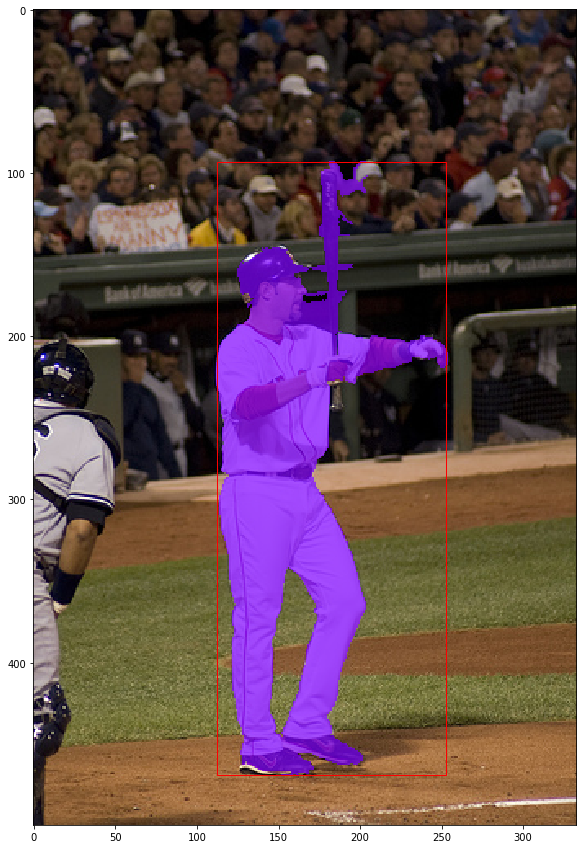

In [17]:
first_item = dataset[10]
bb = first_item[1]['boxes'][0]
mm = first_item[1]['masks'][0]
show_overlay(first_item[0], mm, bb)

## Fine Tuning Model 

### Import Pretrained Models and Set Heads to New Instances of the Same Predictor for Retraining

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [0]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5998 (delta 2), reused 1 (delta 0), pack-reused 5994
Receiving objects: 100% (5998/5998), 9.57 MiB | 8.73 MiB/s, done.
Resolving deltas: 100% (3989/3989), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be37608 version check against PyTorch's CUDA version


In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

### Split the Dataset and Feed Into a Generator

In [0]:
dataset_tr = ICosegDataset(root+'/', get_transform(train=True))
dataset_ts = ICosegDataset(root+'/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_tr)).tolist()
dataset_tr = torch.utils.data.Subset(dataset_tr, indices[:-10])
dataset_ts = torch.utils.data.Subset(dataset_ts, indices[-10:])


In [0]:
data_loader_tr = torch.utils.data.DataLoader(
    dataset_tr, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_ts = torch.utils.data.DataLoader(
    dataset_ts, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [0]:
print( "Size of the training set: ", len(data_loader_tr))
print( "Size of the test set: ", len(data_loader_ts))

Size of the training set:  31
Size of the test set:  10


### THE FUNSIES
- Define device (GPU vs CPU)
- Get the model set up
- define an optimizer
- define a LR adaptor
- train model for 10 epochs

#### Credit:
Pytorch Tutorial [Finetuning MaskRCNN](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


In [0]:
# gpu instance for

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001,
                            momentum=0.9, weight_decay=0.0005)
criterion = nn.CrossEntropyLoss().cuda(args.gpu)
# optimizer = torch.optim.Adam(params, lr=1*10e-8)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_tr, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_ts, device=device)

Epoch: [0]  [ 0/31]  eta: 0:00:25  lr: 0.000034  loss: 5.6520 (5.6520)  loss_classifier: 0.7324 (0.7324)  loss_box_reg: 0.0611 (0.0611)  loss_mask: 4.8119 (4.8119)  loss_objectness: 0.0393 (0.0393)  loss_rpn_box_reg: 0.0072 (0.0072)  time: 0.8265  data: 0.3413  max mem: 1733
Epoch: [0]  [10/31]  eta: 0:00:05  lr: 0.000367  loss: 1.8235 (3.3636)  loss_classifier: 0.6808 (0.5888)  loss_box_reg: 0.0828 (0.0840)  loss_mask: 1.3795 (2.6547)  loss_objectness: 0.0122 (0.0295)  loss_rpn_box_reg: 0.0041 (0.0066)  time: 0.2659  data: 0.0348  max mem: 1733
Epoch: [0]  [20/31]  eta: 0:00:02  lr: 0.000700  loss: 1.2400 (2.2119)  loss_classifier: 0.1637 (0.3583)  loss_box_reg: 0.0663 (0.0750)  loss_mask: 0.8505 (1.7414)  loss_objectness: 0.0117 (0.0278)  loss_rpn_box_reg: 0.0053 (0.0095)  time: 0.2071  data: 0.0044  max mem: 1733
Epoch: [0]  [30/31]  eta: 0:00:00  lr: 0.001000  loss: 0.4579 (1.6206)  loss_classifier: 0.0877 (0.2686)  loss_box_reg: 0.0660 (0.0705)  loss_mask: 0.3122 (1.2506)  loss_ob

## Save the Model

## Do Some Evaluations

### On Some Test Set Images

In [0]:
def show_from_ts(idx):
  img, target = dataset_ts[idx]
  with torch.no_grad():
      prediction = model([img.to(device)])

  img = np.transpose(np.array(img), (1,2,0))

  mask = target['masks'][0]
  bb = target['boxes'][0]

  fig, axs = plt.subplots(1, 3, figsize=(15,15))


  masked = np.ma.masked_where(mask == 0, mask)
  axs[0].imshow(img, 'gray', interpolation='none')
  axs[0].imshow(masked, cmap='rainbow', interpolation='none', alpha=0.7)
  axs[0].set_title("Ground Truth")


  bb = prediction[0]['boxes'][0]
  mask = np.array(prediction[0]['masks'][0, 0].cpu())

  masked  = np.ma.masked_where(mask == 0, mask)
  axs[1].imshow(img, 'gray', interpolation='none')
  axs[1].imshow(masked, cmap='rainbow', interpolation='none', alpha=0.7)
  axs[1].set_title("Predicted")

  axs[2].imshow(img * mask[:,:,np.newaxis])
  axs[2].set_title("What it looks like")

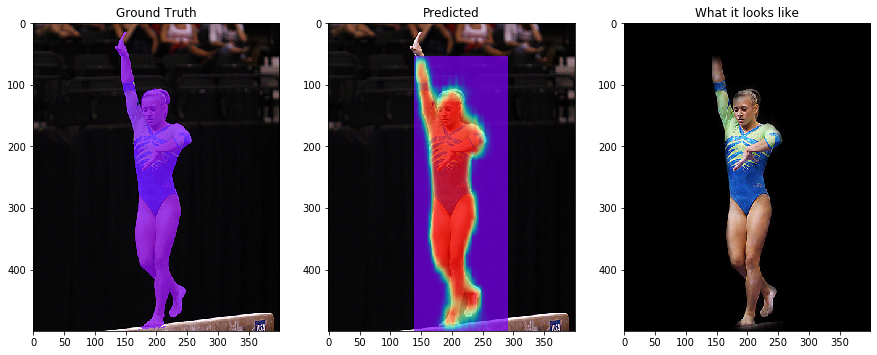

In [0]:
show_from_ts(0)

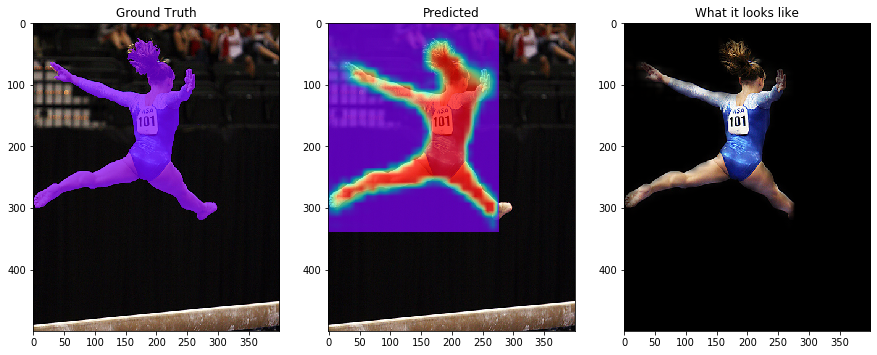

In [0]:
show_from_ts(1)

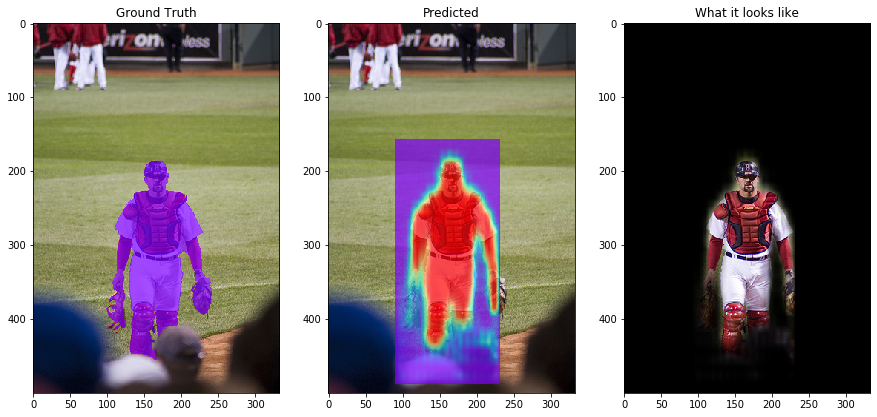

In [0]:
show_from_ts(2)

# Do Some Evals

In [0]:
from torchvision import transforms
def gen_prediction(img_path):

  img = Image.open(img_path)
  
  # preprocess image
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  img_t = transform(img)

  # print(img_t.shape)
  batch_t = torch.unsqueeze(img_t, 0) # reshapes at 0 axis
  # print(batch_t.shape)
    
  with torch.no_grad():
      prediction = model(batch_t.to(device))
  
  return img_t, prediction

In [0]:
def show_prediction(img_path):
  img, pred = gen_prediction(img_path)
  img = np.transpose(np.array(img), (1,2,0))

  fig, axs = plt.subplots(1, 3, figsize=(20,20))
  axs[0].imshow(img)
  axs[0].set_title("OG IMG")

  mask = pred[0]['masks'][0,0]
  mask = np.array(mask.cpu())

  masked = np.ma.masked_where(mask == 0, mask)
  axs[1].imshow(img, 'gray', interpolation='none')
  axs[1].imshow(masked, cmap='rainbow', interpolation='none', alpha=0.7)
  axs[1].set_title("Predicted")

  axs[2].imshow(np.array(img) * mask[:,:,np.newaxis])
  axs[2].set_title("What it looks like")

  return img, pred

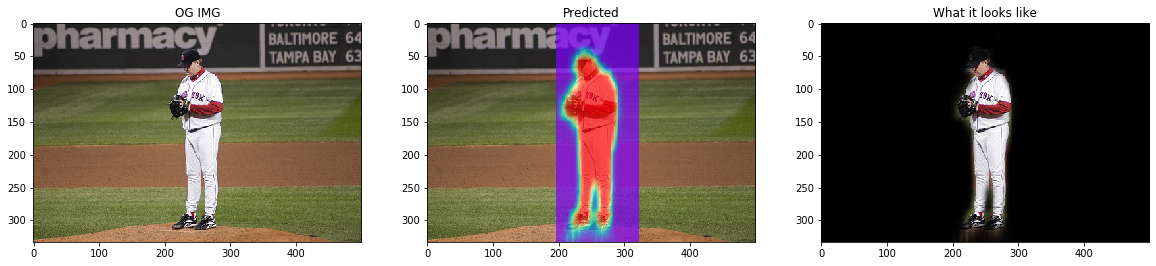

In [0]:
path = root + "/imgs/baseball.jpg"
img, pred = show_prediction(path)

In [0]:
test_img_dir= "/gdrive/My Drive/Colab Notebooks/val_imgs/"

In [0]:
imgs = list(sorted(os.listdir(os.path.join(test_img_dir))))
len(imgs)

11

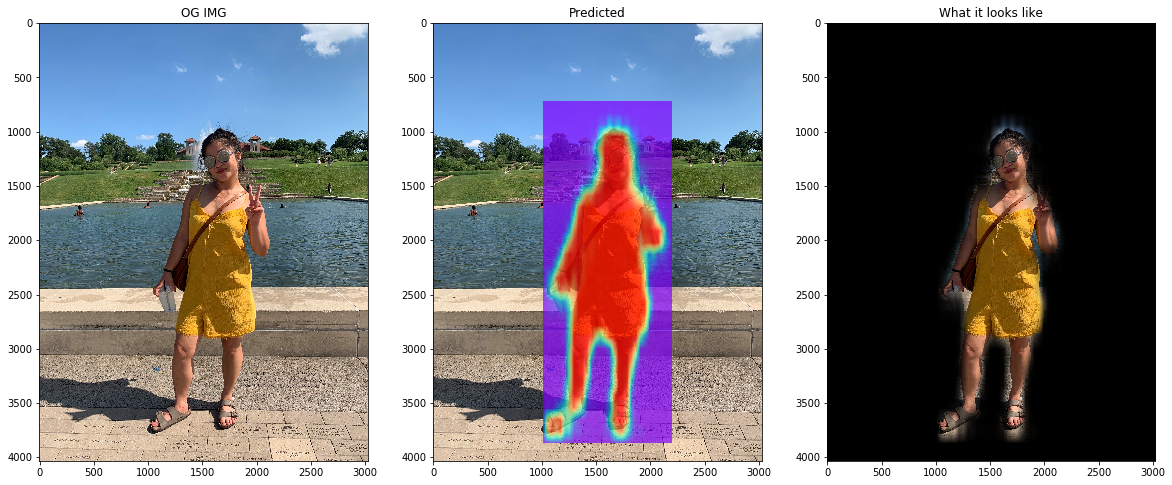

In [0]:
valPreds.append(show_prediction(test_img_dir+imgs[10]))


In [0]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
         